# Check the sentence profanity classification



|  hate speech  | offensive language  |  neither |  
|---|---|---| 
| 0  |  1 |  2 |  

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import re
import os
import math
import pprint as pp


# Data 

## Download data

In [2]:
URL = "https://dl.dropbox.com/s/ewpit86gekpiwk5/hate_dirty_peech_labeled_data.tsv"
path = tf.keras.utils.get_file(URL.split('/')[-1], URL)
data = pd.read_csv(path, sep="\t")


2555904/2552512 [==============================] - 1s 0us/step


## Shuffle data

In [3]:
data = data.sample(frac=1)
data.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
20161,20613,3,1,2,0,1,"RT @therealelp: from @CNN tonight: "" N word or..."
17097,17495,3,2,1,0,0,RT @RihannaHasAids: aight game over. dykes had...
14848,15211,3,1,2,0,1,RT @DETROITSWEETS_: U gotta be retarded to ski...
2720,2793,3,0,3,0,1,@CMBGaming11 @BeechHD oh you mean like how you...
3164,3253,3,0,1,2,2,@FightNightX @NMF4Life khan has been facing no...


## Clean data

In [4]:
data = data[pd.notnull(data['class'])]
data = data[pd.notnull(data['tweet'])]
data = data.drop(data.columns[0], axis=1) 
data = data.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither']) 
 
data["tweet"] = data["tweet"].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 

data["label"] = data["class"]

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
data['class'].astype(str)
data = data.replace({'class': {0: "hate speech", 1: "offensive language", 2: "neither"}})

# Print the first first five rows as default
data.head(50)


,class,tweet,label
20161,offensive language,RT from tonight N word or crackerwhich is m...,1
17097,hate speech,RT aight game over dykes had to ruin it,0
14848,offensive language,RT U gotta be retarded to skip class in college,1
2720,offensive language,oh you mean like how you started to be a cun...,1
3164,neither,khan has been facing nothing but trash since...,2
24036,offensive language,if dey go to linch together she gon eat that p...,1
16076,offensive language,RT Dace SO to them side hos that know they the...,1
8273,offensive language,COME TO TND Atrocities starts at 7 followed by...,1
12426,offensive language,Like my 3rd grade teacher used to say you eith...,1
691,neither,DerekJeter as a lifelong Yankees man I will mi...,2


# Create texts and labels

## Create labels

In [5]:
labels = data["label"].to_list()
print(labels[:10])


[1, 0, 1, 1, 2, 1, 1, 1, 1, 2]


In [6]:
label_count = len(set(labels))
print(label_count)


3


### Create texts sequences

In [7]:
texts = data["tweet"].to_numpy()
type(texts)
print(texts[:10])


['RT  from  tonight  N word or crackerwhich is more offensive probably the one you wont spell out you fucking hacks8230'
 'RT  aight game over dykes had to ruin it '
 'RT  U gotta be retarded to skip class in college'
 '  oh you mean like how you started to be a cunt to JP about something that has nothing to do with you'
 '  khan has been facing nothing but trash since his L to Garcia'
 'if dey go to linch together she gon eat that pussy befo they come back'
 'RT Dace SO to them side hos that know they the side hos we need more of ya'
 'COME TO TND Atrocities starts at 7 followed by Lost Cause Auramea Night Verses and NORMA JEAN Lets fill this bitch'
 'Like my 3rd grade teacher used to say you either eat pussy or you are one whats it gonna be  '
 'DerekJeter as a lifelong Yankees man I will miss you FirstBallot Unanimous']


In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)


In [9]:
word_index = tokenizer.word_index
total_words = len(word_index) + 1
print(total_words) 


27426


In [10]:
sequences = tokenizer.texts_to_sequences(texts)
total_sequences = len(sequences)
print(total_sequences)
print(sequences[:10])


24776
[[3, 83, 315, 169, 436, 73, 10654, 13, 120, 1264, 408, 5, 71, 6, 263, 1633, 55, 6, 78, 10655], [3, 4634, 206, 124, 1177, 125, 7, 3446, 24], [3, 43, 145, 18, 175, 7, 4635, 498, 11, 1105], [224, 6, 250, 14, 69, 6, 683, 7, 18, 1, 181, 7, 7281, 59, 233, 10, 158, 271, 7, 64, 26, 6], [5673, 158, 128, 3447, 271, 34, 53, 374, 89, 1805, 7, 10656], [32, 793, 79, 7, 10657, 601, 51, 279, 167, 10, 22, 5674, 38, 146, 105], [3, 10658, 37, 7, 70, 235, 1305, 10, 65, 38, 5, 235, 1305, 68, 104, 120, 16, 97], [146, 7, 10659, 10660, 1806, 54, 1072, 1566, 123, 479, 150, 10661, 251, 7282, 8, 10662, 7283, 382, 3932, 20, 2], [14, 9, 2568, 945, 1073, 452, 7, 95, 6, 459, 167, 22, 73, 6, 50, 71, 387, 24, 153, 18], [5675, 74, 1, 7284, 193, 91, 4, 107, 472, 6, 10663, 10664]]


#### 🍼Define max length 

In [11]:
max_len = max([len(s) for s in sequences])
print(max_len)
max_len =  int(max_len / 3.6)
print(max_len)


57
15


### Shift each sequence to generate more "texts"

In [12]:
def shift_sequences(unshifted_sequences, labels):
  shifted = []
  i = -1
  for seq in unshifted_sequences:
    i = i + 1
    length = len(seq)
    shifted.append((seq, labels[i]))
    if length > 3: [shifted.append((seq[:-shift], labels[i])) for shift in range(1, length-1)]  
  return shifted


In [13]:
shifted_sequences_labels = np.array(shift_sequences(sequences, labels))

sequences = shifted_sequences_labels[:,:-1][:,0]
print(sequences[:3])

labels = shifted_sequences_labels[:,-1]
print(labels[:3])

total_sequences = len(sequences)
print(total_sequences)

[list([3, 83, 315, 169, 436, 73, 10654, 13, 120, 1264, 408, 5, 71, 6, 263, 1633, 55, 6, 78, 10655])
 list([3, 83, 315, 169, 436, 73, 10654, 13, 120, 1264, 408, 5, 71, 6, 263, 1633, 55, 6, 78])
 list([3, 83, 315, 169, 436, 73, 10654, 13, 120, 1264, 408, 5, 71, 6, 263, 1633, 55, 6])]
[1 1 1]
304862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [14]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    padding = "post",
    maxlen = max_len
)

#padded_sequences = tf.expand_dims(padded_sequences, axis=-1)
print(type(padded_sequences))
print(padded_sequences[:5])

labels = np.asarray(labels).astype(np.int)
print(labels[:5])

<class 'numpy.ndarray'>
[[   73 10654    13   120  1264   408     5    71     6   263  1633    55
      6    78 10655]
 [  436    73 10654    13   120  1264   408     5    71     6   263  1633
     55     6    78]
 [  169   436    73 10654    13   120  1264   408     5    71     6   263
   1633    55     6]
 [  315   169   436    73 10654    13   120  1264   408     5    71     6
    263  1633    55]
 [   83   315   169   436    73 10654    13   120  1264   408     5    71
      6   263  1633]]
[1 1 1 1 1]


## Divide training data and testing data

### Training data

In [15]:
boundary = int(.85 * total_sequences)

training_sequences = padded_sequences[:boundary]
training_labels = labels[:boundary]

print(len(training_sequences))
print(len(training_labels))

print(training_sequences[:5])
print(training_labels[:5])


259132
259132
[[   73 10654    13   120  1264   408     5    71     6   263  1633    55
      6    78 10655]
 [  436    73 10654    13   120  1264   408     5    71     6   263  1633
     55     6    78]
 [  169   436    73 10654    13   120  1264   408     5    71     6   263
   1633    55     6]
 [  315   169   436    73 10654    13   120  1264   408     5    71     6
    263  1633    55]
 [   83   315   169   436    73 10654    13   120  1264   408     5    71
      6   263  1633]]
[1 1 1 1 1]


### Testing data

In [16]:
testing_sequences = padded_sequences[boundary:]
testing_labels = labels[boundary:]

total_testing_sequences = len(testing_sequences)
print(total_testing_sequences)
print(len(testing_labels))

print(testing_sequences[:5])
print(testing_labels[:5])


45730
45730
[[24949    86   158   103   900  1433  1924 24950   547    16  1425    50
     17     5   400]
 [    5 24949    86   158   103   900  1433  1924 24950   547    16  1425
     50    17     5]
 [    3     5 24949    86   158   103   900  1433  1924 24950   547    16
   1425    50    17]
 [    3     5 24949    86   158   103   900  1433  1924 24950   547    16
   1425    50     0]
 [    3     5 24949    86   158   103   900  1433  1924 24950   547    16
   1425     0     0]]
[2 2 2 2 2]


# Machine-learning

## Hyperparameters

In [17]:
epochs = 50#100
embedding_dim = 215


## Utils, like output, graphic etc....

### Table of *prediction*

In [18]:
import matplotlib.pyplot as plt

def predict_output(texts, predicated_classes):
    fig, ax = plt.subplots()
    ax.axis('off')

    predicated_classes = np.expand_dims(predicated_classes, axis=-1)

    table = ax.table(
             rowLabels=texts,  
             colLabels=["classification"],  
             cellText=predicated_classes, 
             cellLoc="center", 
             loc="center"
    )
    table.scale(0.5, 1)  
    
    ax.set_title('0: "hate speech", 1: "offensive language", 2: "neither"',
              fontweight ="bold")

    fig.tight_layout()
    plt.show()

### 📊Grpahic of training

In [19]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

def plot(history, m0, m1): 
  h_m0=history.history[m0] 
  h_m1=history.history[m1] 
  epochs=range(len(h_m0))  
  plt.plot(epochs, h_m0, 'b', m0) 
  plt.figure()  
  plt.plot(epochs, h_m1, 'b', m1)  

## Methods

### 🎉Method of building model

In [20]:
def build_model(*layers):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Embedding(
            input_dim=total_words,
            output_dim=embedding_dim,
            input_shape=[None,]
        ),
    ) 
    [model.add(layer) for layer in layers]

    model.add(tf.keras.layers.Dropout(.12))
    model.add(tf.keras.layers.Dense(int(total_words / 2),
                                    activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(label_count, activation=tf.keras.activations.softmax))
 
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"],
    )
    model.summary()

    return model

In [21]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

### 🏋️‍♀️Method of traning 

In [22]:
def train_model(model):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    return model.fit(
              x=training_sequences, 
              y=training_labels, 
              #validation_split
              #validation_data=(valid_sequences, valid_labels)
              #wont make sense see: https://stackoverflow.com/a/57391324/1835650
              verbose=1,
              epochs=epochs,
              callbacks=[earlyStop])

### Method of prediction

In [23]:
def predict(model, texts):
    tokenizer.fit_on_texts(texts)
    tokenized_texts = tokenizer.texts_to_sequences(texts)
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_texts,
        maxlen = max_len,
        padding = "post", 
    )
    predicted = model.predict(padded_texts)
    predicted_classes = np.argmax(predicted, axis=-1)

    print("texts: {}".format(texts))
    print("tokenized_texts: {}".format(tokenized_texts))
    print("padded_texts: {}".format(padded_texts))
    print("predicted: {}".format(predicted))
    print("predicted class: {}".format(predicted_classes))
    predict_output(texts, predicted_classes)

### Method of evaluation

In [33]:
def evaluate_model(model):
  print("Evaluate on test data")
  results = model.evaluate(testing_sequences, testing_labels) 

## Try model without training

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 215)         5896590   
_________________________________________________________________
global_average_pooling1d (Gl (None, 215)               0         
_________________________________________________________________
dropout (Dropout)            (None, 215)               0         
_________________________________________________________________
dense (Dense)                (None, 13713)             2962008   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 41142     
Total params: 8,899,740
Trainable params: 8,899,740
Non-trainable params: 0
_________________________________________________________________
texts: ['hello', 'bad man', 'fuck you', 'suck you', 'you bitch']
tokenized_texts: [[1581], [84, 91], [36, 6], [3

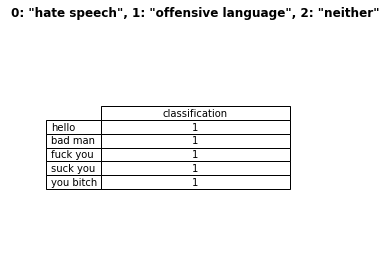

In [25]:
model = build_model(tf.keras.layers.GlobalAveragePooling1D())
predict(model, ["hello", "bad man", "fuck you", "suck you", "you bitch"])

## 💥Training

In [26]:
model = build_model( 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),
)
history = train_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 215)         5896590   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         352256    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13713)             891345    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

## Training completed

### Result

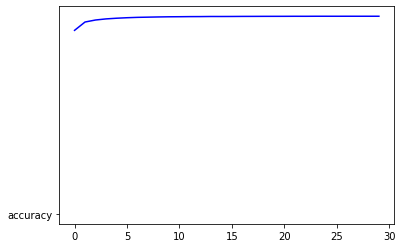

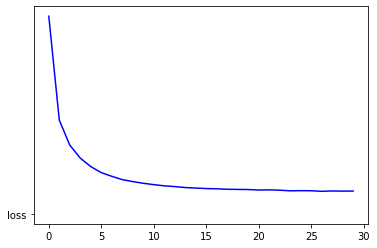

In [27]:
plot(history, "accuracy", "loss")


### Try to predict

texts: ['good people']
tokenized_texts: [[90, 111]]
padded_texts: [[ 90 111   0   0   0   0   0   0   0   0   0   0   0   0   0]]
predicted: [[1.3792946e-04 9.4458139e-01 5.5280693e-02]]
predicted class: [1]


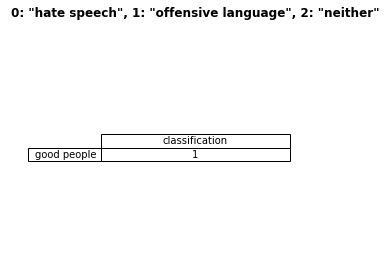

In [28]:
predict(model, ["good people"])


### Evaluation

In [34]:
evaluate_model(model)

Evaluate on test data
1430/1430 [==============================] - 9s 6ms/step - loss: 3.5346 - accuracy: 0.7698
